In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

# SpaceX Booster Landing Prediction

## Introduction

In this project, we developed a machine learning model to predict the landing success of the first stage of the Falcon 9 rocket, using data from historical SpaceX launches.


The data used in this project is **not official SpaceX data**.
**Since SpaceX does not publicly release detailed datasets for every launch**, we worked with publicly available and community-compiled datasets.


Rocket reusability plays a key role in reducing the cost of space missions, which makes accurate prediction of landing outcomes highly relevant for the further development of reusable launch technologies.

We engineered features such as payload mass, orbit type (one-hot encoded), technical specifications of the booster (Block, Flights, Reused, GridFins, Legs), and flight number, to train a logistic regression model with polynomial expansion (degree=3).
The model was then evaluated using metrics such as accuracy, precision, recall, F1-score, the confusion matrix, and ROC curve, providing a detailed view of its performance.

Several examples of failed landings are shown below:

![Falcon 9 Crash](images/crash.gif)

Most of the failed landings were intentional and planned — SpaceX often performs controlled descents into the ocean for testing and data collection.

This is what the Falcon 9 rocket looks like:

![Falcon 9](images/falcon-9-v1-2-b5__starlink-2__1.jpg)

In [3]:
df = pd.read_csv(r'data/dataset_part_2.csv')

In [4]:
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060,-80.603956,28.608058,1
86,87,2020-10-06,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
87,88,2020-10-18,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
88,89,2020-10-24,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1


# EDA - Exploring Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
 17  Class           90 non-null     int64

In [7]:
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,-86.366477,29.449963,0.666667
std,26.124701,4694.671720,1.213172,1.595288,1.710254,14.149518,2.141306,0.474045
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857,0.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,-80.577366,28.608058,1.000000
max,90.000000,15600.000000,6.000000,5.000000,5.000000,-80.577366,34.632093,1.000000


In [6]:
df.isna().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
Class              0
dtype: int64

Here im looking for missing values for this data set.


As we can see there is **26** missing values in **Landing Pad**

In [8]:
df.duplicated().any()

np.False_

Here im looking is there any duplicates in this dataset, and as we can see **there is none duplicates** as we got False

## Chooesing potentical features

After examining the data, i decided to take this as main potential features.

Now i did that based on my common knowlage about what can create biggest impact, but yet we are going to see if it was good choice.

In [9]:
features = [
    "FlightNumber",
    "PayloadMass",
    "Orbit",
    "Flights",
    "GridFins",
    "Reused",
    "Legs",
    "Block",
    "Class"
]

In [10]:
dff = df[features].copy()

In [11]:
dff

,FlightNumber,PayloadMass,Orbit,Flights,GridFins,Reused,Legs,Block,Class
0,1,6104.959412,LEO,1,False,False,False,1.0,0
1,2,525.000000,LEO,1,False,False,False,1.0,0
2,3,677.000000,ISS,1,False,False,False,1.0,0
3,4,500.000000,PO,1,False,False,False,1.0,0
4,5,3170.000000,GTO,1,False,False,False,1.0,0
...,...,...,...,...,...,...,...,...,...
85,86,15400.000000,VLEO,2,True,True,True,5.0,1
86,87,15400.000000,VLEO,3,True,True,True,5.0,1
87,88,15400.000000,VLEO,6,True,True,True,5.0,1
88,89,15400.000000,VLEO,3,True,True,True,5.0,1


In [12]:
corr_matrix = dff.drop(columns=["Orbit"]).corr()

At this point, I selected **Class** as the target variable for prediction.
From the earlier `data.describe()` output, we can see that the mean is around **0.66**, which indicates that about **66% of the data belongs to Class = 1** (successful landings).
This suggests that the dataset may be somewhat unbalanced, so it is worth exploring this further.

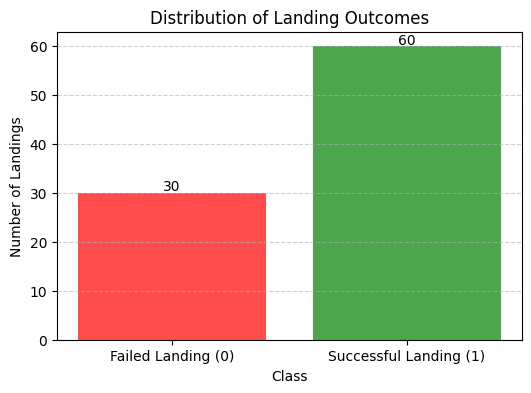

In [13]:
class_counts = dff["Class"].value_counts().sort_index()
labels = ["Failed Landing (0)", "Successful Landing (1)"]
values = [class_counts[0], class_counts[1]]
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["red", "green"], alpha=0.7)
plt.title("Distribution of Landing Outcomes")
plt.ylabel("Number of Landings")
plt.xlabel("Class")
plt.grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha="center")
plt.show()

Here we can see that the data is not perfectly balanced between successful and failed landings. This is not a major issue, but it is important to keep in mind and later apply the `stratify` parameter from scikit-learn when splitting into train and test sets, to ensure an even class distribution.

Looking at out data we can see there is good amount of numeric values witch is great, but we can also see there are some colums that are bool and object.

So we are gonna use bool one, but for now we have to ignore object since it can't be represented in correlation matrix because its object ofc.

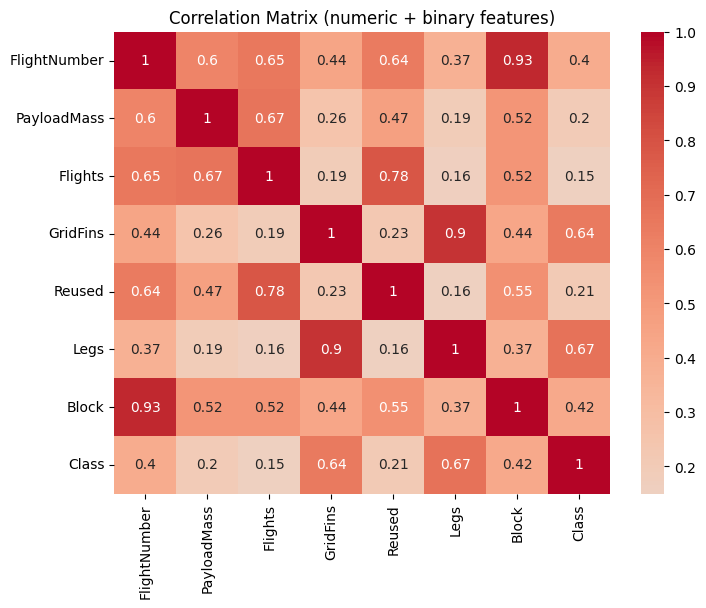

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (numeric + binary features)")
plt.show()

## Correlation Analysis – Key Insights

From the correlation matrix of the selected features, we observed the following:

- **Legs (0.67) and GridFins (0.64)** show the strongest correlation with the target variable (*Class*).
  - This aligns with SpaceX’s landing procedures: grid fins are always deployed when a controlled landing is attempted, while landing legs are only deployed at the final stage of descent.
  - Their presence is therefore a strong indicator of a higher probability of success, although not a guarantee (abort procedures can still occur).
  - The typical sequence goes as follows:
    1. Booster alignment check – if trajectory is stable, continue.
    2. Grid fins are engaged to control descent.
    3. At a defined distance, perform the landing burn – if trajectory remains correct, proceed.
    4. Only at the final phase, landing legs are deployed.
  - In practice, legs were successfully deployed about **67%** of the time, while in roughly **23%** of cases they were not, which directly reflects in the success ratio.

- **Block (0.42) and FlightNumber (0.40)** also show moderate correlation with *Class*.
  - This reflects the engineering improvements of later Falcon 9 versions and the overall increased reliability of later launches.

- **PayloadMass (0.20), Reused (0.21), and Flights (0.15)** have weaker direct correlations with *Class*.
  - However, they may still provide useful information when combined with other variables, especially through polynomial interactions (e.g., `PayloadMass × Block`, `Reused × Flights`).

### Conclusion of this data analysis
The strongest individual signals for predicting landing success are **Legs** and **GridFins**, followed by **Block** and **FlightNumber** as supporting factors.
Other features contribute less on their own but may still be informative when higher-order interactions are included (e.g., with **polynomial features of degree 3**).

# Feature Engineering

In this part we are gonna:

1. Convert features with boot to be 0 and 1 so from (True and False) -> (0, 1)
2. We will do one-hot-encoding approach for our object data
3. Later on we are going to use poly on deggree 3 - **NOT IN THIS SECTION**

In [15]:
dff["GridFins"] = dff["GridFins"].map({False: 0, True: 1})
dff["Reused"]   = dff["Reused"].map({False: 0, True: 1})
dff["Legs"]     = dff["Legs"].map({False: 0, True: 1})

Here we converted bool to numeric

In [16]:
dff

,FlightNumber,PayloadMass,Orbit,Flights,GridFins,Reused,Legs,Block,Class
0,1,6104.959412,LEO,1,0,0,0,1.0,0
1,2,525.000000,LEO,1,0,0,0,1.0,0
2,3,677.000000,ISS,1,0,0,0,1.0,0
3,4,500.000000,PO,1,0,0,0,1.0,0
4,5,3170.000000,GTO,1,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...
85,86,15400.000000,VLEO,2,1,1,1,5.0,1
86,87,15400.000000,VLEO,3,1,1,1,5.0,1
87,88,15400.000000,VLEO,6,1,1,1,5.0,1
88,89,15400.000000,VLEO,3,1,1,1,5.0,1


We are checking for nan values just in case

In [17]:
dff.isna().sum()

FlightNumber    0
PayloadMass     0
Orbit           0
Flights         0
GridFins        0
Reused          0
Legs            0
Block           0
Class           0
dtype: int64

And here we are going to do one-hot-encoding useing pandas lib

In [18]:
dff_ohe = pd.get_dummies(dff, columns=["Orbit"])
dff_f = dff_ohe.astype(int)

In [19]:
dff_f

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO
0,1,6104,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,2,525,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,3,677,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,4,500,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,5,3170,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15400,2,1,1,1,5,1,0,0,0,0,0,0,0,0,0,0,1
86,87,15400,3,1,1,1,5,1,0,0,0,0,0,0,0,0,0,0,1
87,88,15400,6,1,1,1,5,1,0,0,0,0,0,0,0,0,0,0,1
88,89,15400,3,1,1,1,5,1,0,0,0,0,0,0,0,0,0,0,1


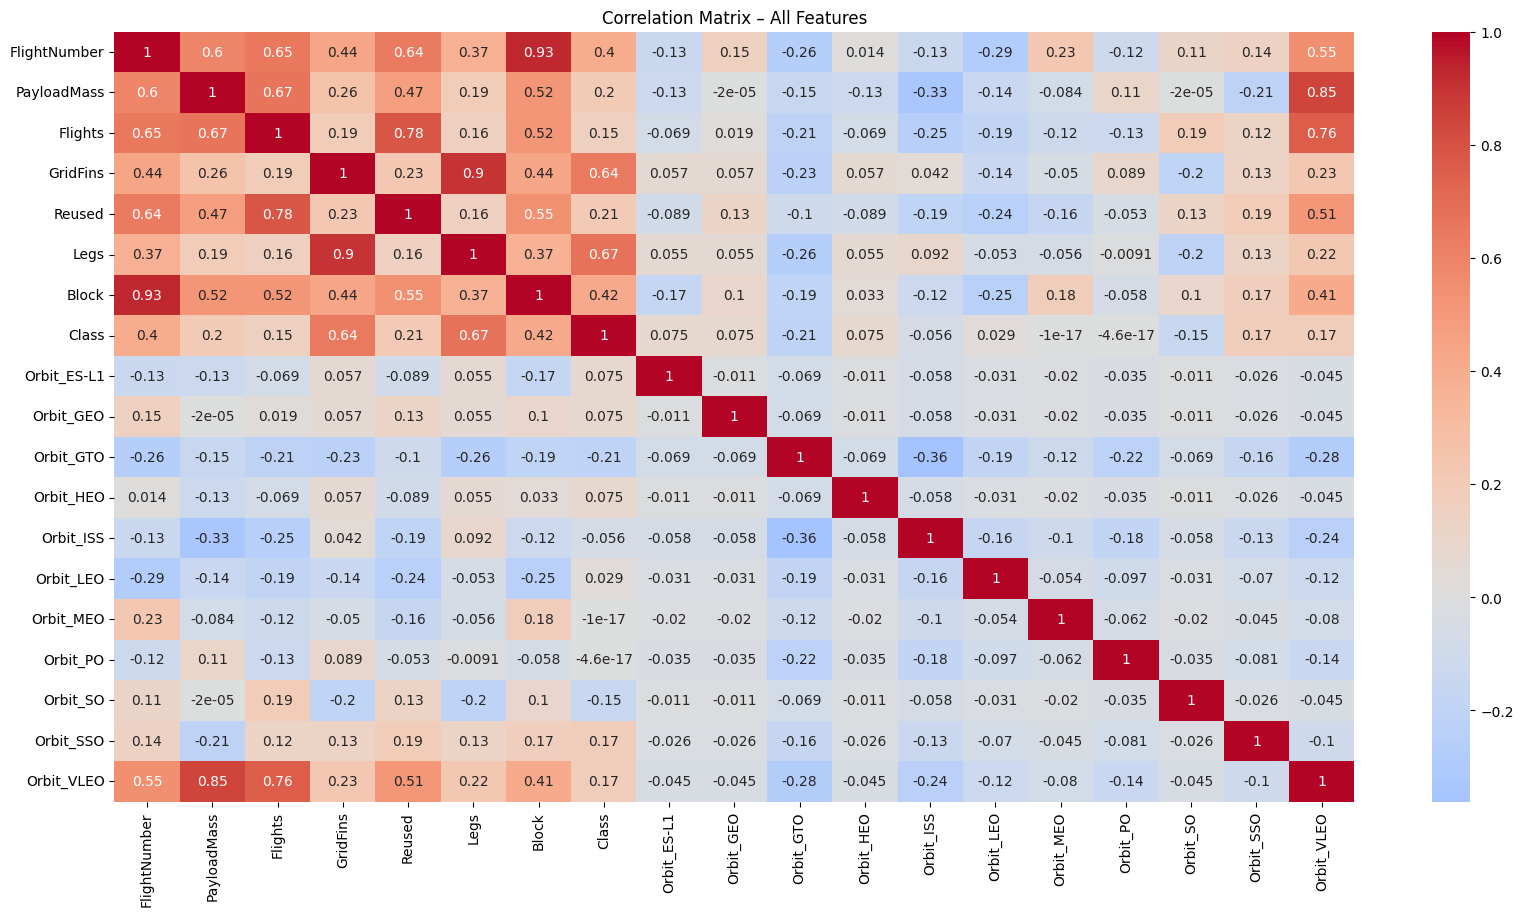

In [20]:
corr = dff_f.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.title("Correlation Matrix – All Features")
plt.show()

## Correlation Analysis – Extended for Orbital Insights

From the updated correlation with our orbit data that was **OHE** in matrix we can highlight the following:

#### **Orbit dummy variables - useing OHE:**
  - **Negative correlations:** Orbit_GTO (-0.21), Orbit_LEO (-0.25), Orbit_ISS (-0.12 to -0.33) - missions to these orbits are less likely to result in successful landings.
  - **Positive correlations:** Orbit_VLEO (0.17), Orbit_SSO (0.17) - missions to these orbits are more likely to result in successful landings.
  - This matches reality where GTO and ISS missions demand higher energy, making booster recovery more challenging.

### Conclusion
The dataset is now well-prepared:
- We have strong direct signals (**Legs, GridFins, Block, FlightNumber**)
- Additional weaker signals that can be leveraged with **polynomial features**

![Falcon 9](images/Where_and_why_we_whizz_around_Earth_pillars.jpg)

# Model Training

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import kockice as k # - moj lib

In this step, we split the dataset into numerical and binary features, OHE orbit features, and the target label, so that the data is properly structured for model training.

We are going to combine it later

In [22]:
poly_cols = ["FlightNumber", "PayloadMass", "Flights", "Block", "GridFins", "Reused", "Legs"]
orbit_cols = [c for c in dff.columns if c.startswith("Orbit_")]
target_col = "Class"

Here we split the dataset into training and testing sets using `stratified sampling` as we mentiond before, ensuring the class distribution remains balanced for model evaluation.

In [23]:
X = dff[poly_cols + orbit_cols].copy() # so here we will combine all features
Y = dff[target_col].astype(int).copy()

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, stratify=Y, random_state=42
)

print("Train:", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape,  Y_test.shape)

Train: (63, 7) (63,)
Test:  (27, 7) (27,)


Here we take the base numerical/binary features and standardize them (mean=0, std=1), fitting on the training set and applying the same parameters to the test set.

In [24]:
Xtr_base = X_train[poly_cols].to_numpy().T   # (poly_cols, m_train)
Xte_base = X_test[poly_cols].to_numpy().T    # (poly_cols, m_test)

Xtr_std, (mu, sd) = k.standardize_rows(Xtr_base)
Xte_std = (Xte_base - mu) / sd

Here we expand the standardized features using Polynomial Features of degree 3 to capture nonlinear relationships and interactions between variables.

In [25]:
# Polynomial Features (degree=3)
poly3 = PolynomialFeatures(degree=3, include_bias=False)
Xtr_poly = poly3.fit_transform(Xtr_std.T).T
Xte_poly = poly3.transform(Xte_std.T).T

Here we keep the Orbit OHE variables as 0/1 features and combine them with the polynomial features to form the final training and testing feature sets.

It is really important **not** to apply polynomial expansion on one-hot encoded variables, because that would only create redundant or meaningless combinations (e.g., `Orbit_GTO × Orbit_LEO`), which cannot occur at the same time and would add noise instead of useful information.

In [26]:
Xtr_orbit = X_train[orbit_cols].to_numpy().T
Xte_orbit = X_test[orbit_cols].to_numpy().T

X_train_fe = np.vstack([Xtr_poly, Xtr_orbit])
X_test_fe  = np.vstack([Xte_poly, Xte_orbit])

Here we reshape the target `Class` into the form `(1, m)` so it matches the expected input/output shape for our model, and print the dimensions of both features and labels to confirm everything is aligned.

In [27]:
Y_trainF = Y_train.to_numpy().reshape(1, -1)
Y_testF  = Y_test.to_numpy().reshape(1, -1)

print("X_train_fe:", X_train_fe.shape, "| X_test_fe:", X_test_fe.shape)
print("Y_trainF:", Y_trainF.shape, "| Y_testF:", Y_testF.shape)

X_train_fe: (119, 63) | X_test_fe: (119, 27)
Y_trainF: (1, 63) | Y_testF: (1, 27)


This is casual marimo inputs so we can interact better with other cells, but in this one we can tweek:

- Learning rate
- Epochs / interations
- L2 / regularizations
- Threshold / if > 0.5 it landed (that by default)

## Model

Finally, the model. As before, I reuse the library functions I implemented in the previous project, with a short recap of what each does:

- **linear_init_params** – initializes the parameters (weights and bias).
  *Note:* even though it says *linear*, this initialization works the same for both linear and logistic regression.

- **forward_logistic** – performs a forward pass (like `forward_linear`), but wrapped with the **sigmoid activation** to output probabilities.

- **bce_loss** – computes the **Binary Cross-Entropy (Log Loss)**, the standard loss function for logistic regression.

- **logistic_backprop** – computes gradients for logistic regression, taking into account the sigmoid activation.

- **gd_update** – performs one step of **gradient descent**, updating the parameters with the computed gradients.

In [28]:
lr         = 0.02
epochs     = 800
lambda_l2  = 0.02
threshold  = 0.50

In [29]:
params = k.init_params(n_x=X_train_fe.shape[0], n_y=1, seed=42)
history = []

for ep in range(epochs):
    cache = k.forward_logistic(X_train_fe, params)
    A_hat = cache["A"]                     # (1, m)
    bce = k.bce_loss(A_hat, Y_trainF)
    l2_penalty = (lambda_l2/(2*Y_trainF.shape[1])) * np.sum(params["W"]**2)
    cost = bce + l2_penalty
    grads = k.logistic_backprop(X_train_fe, Y_trainF, cache)
    grads["dW"] += (lambda_l2/Y_trainF.shape[1]) * params["W"]
    params = k.gd_update(params, grads, lr=lr)
    history.append(cost)
    if (ep+1) % 20 == 0:
        print(f"[{ep+1:4d}] BCE(train) = {cost:.6f}")

print("Final train BCE:", history[-1])

[  20] BCE(train) = 1.301896
[  40] BCE(train) = 0.958140
[  60] BCE(train) = 0.785194
[  80] BCE(train) = 0.675158
[ 100] BCE(train) = 0.601962
[ 120] BCE(train) = 0.550461
[ 140] BCE(train) = 0.509986
[ 160] BCE(train) = 0.475542
[ 180] BCE(train) = 0.445189
[ 200] BCE(train) = 0.418015
[ 220] BCE(train) = 0.393431
[ 240] BCE(train) = 0.370995
[ 260] BCE(train) = 0.350392
[ 280] BCE(train) = 0.331456
[ 300] BCE(train) = 0.314173
[ 320] BCE(train) = 0.298670
[ 340] BCE(train) = 0.285132
[ 360] BCE(train) = 0.273652
[ 380] BCE(train) = 0.264121
[ 400] BCE(train) = 0.256256
[ 420] BCE(train) = 0.249711
[ 440] BCE(train) = 0.244181
[ 460] BCE(train) = 0.239426
[ 480] BCE(train) = 0.235272
[ 500] BCE(train) = 0.231594
[ 520] BCE(train) = 0.228301
[ 540] BCE(train) = 0.225326
[ 560] BCE(train) = 0.222617
[ 580] BCE(train) = 0.220136
[ 600] BCE(train) = 0.217850
[ 620] BCE(train) = 0.215736
[ 640] BCE(train) = 0.213773
[ 660] BCE(train) = 0.211944
[ 680] BCE(train) = 0.210235
[ 700] BCE(tra

## Graphs BCE/Epochs

In marimo i used ploty, but here i used matplotlib, because ploty can't be shown in GitHub ipynb preview

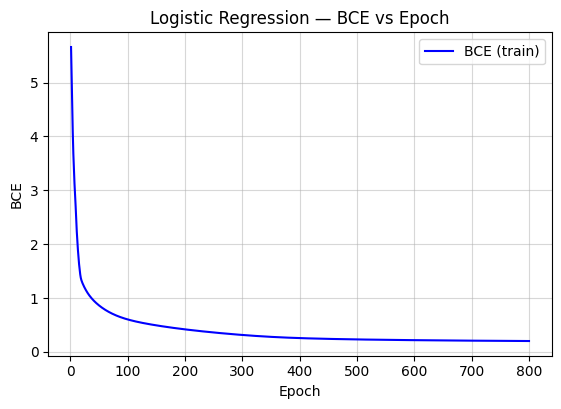

In [38]:
plt.figure(figsize=(6.5, 4.2))  # ~650x420 px
plt.plot(range(1, len(history)+1), history, color="blue", label="BCE (train)")

plt.title("Logistic Regression — BCE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("BCE")
plt.legend()
plt.grid(alpha=0.5)

plt.show()

The ROC curve shows that the model performs well, achieving an AUC of 0.84, which indicates a strong ability to distinguish between successful and failed landings.

## Model Accuracy

In [31]:
cache_train = k.forward_logistic(X_train_fe, params)
A_train = cache_train["A"].flatten()
y_train = Y_trainF.flatten().astype(int)
y_pred_train = (A_train >= 0.5).astype(int)
acc_train = (y_pred_train == y_train).mean() * 100

print(f"Train Accuracy: {acc_train:.2f}%")

cache_test = k.forward_logistic(X_test_fe, params)
A_test = cache_test["A"].flatten()
y_test = Y_testF.flatten().astype(int)
y_pred_test = (A_test >= 0.5).astype(int)
acc_test = (y_pred_test == y_test).mean() * 100

print(f"Test Accuracy: {acc_test:.2f}%")

Train Accuracy: 92.06%
Test Accuracy: 85.19%


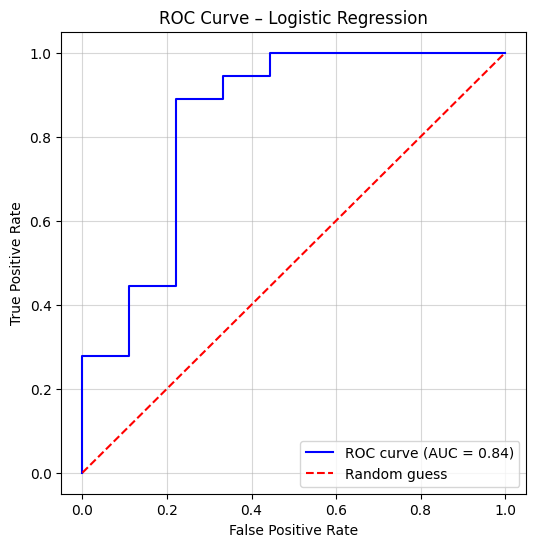

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = Y_testF.flatten().astype(int)
y_scores = A_test

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1], [0,1], color="red", linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Score - bonus

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

prec = precision_score(y_test, y_pred_test)
rec  = recall_score(y_test, y_pred_test)
f1   = f1_score(y_test, y_pred_test)

print(f"Precision: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-score:  {f1:.2f}")

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

Precision: 0.89
Recall:    0.89
F1-score:  0.89
Confusion Matrix:
 [[ 7  2]
 [ 2 16]]


The model achieves balanced performance with **Precision, Recall, and F1-score all at 0.89**, which indicates that it is equally good at identifying both successful and failed landings.
The confusion matrix shows only a few misclassifications (2 false positives and 2 false negatives), confirming that the model generalizes well on the test set.

## Future Work

This was a fun project that took me just a few hours to put together for now, it’s the only one related to space.
But stay tuned: I’m already *cooking up* something much cooler! not just another notebook, but a real project with neural networks and rocket landings (hint: KSP 🚀).